# Iterated Prisoner's Dilemma On A Network

## Imports and Config

In [44]:
import math
import random
import numpy as np
import pandas as pd
import networkx as nx
from pathlib import Path
from functools import partial
import matplotlib.pyplot as plt
from dataclasses import dataclass
from IPython.display import Image
import matplotlib.patheffects as pe
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
from matplotlib.ticker import PercentFormatter
from matplotlib.animation import FuncAnimation, PillowWriter


PLOT_DIR = Path("images")
PLOT_DIR.mkdir(parents=True, exist_ok=True)


def _safe_plot_name(name):
    return "".join(ch if ch.isalnum() or ch in "-_." else "_" for ch in name).strip(
        "._"
    )


def save_fig(fig, name, ext="png", dpi=200):
    safe = _safe_plot_name(name) or "plot"
    path = PLOT_DIR / f"{safe}.{ext}"
    fig.savefig(path, dpi=dpi, bbox_inches="tight")
    plt.close(fig)
    return path

In [45]:
RUN_ARCH = True
RUN_PLOTS = True
RUN_STRUCTURE = True
RUN_ROBUSTNESS = True
RUN_ANIMATIONS = True
RUN_UNCERTAINTY = True
RUN_PARAM_SWEEPS = True

SEEDS = list(range(5))

N = 36
TAIL = 50
MEAN_K = 4
STEPS = 100
METRIC_STRIDE = 1

## Matrices

In [46]:
payoff_matrices = {
    "Default": {
        ("C", "C"): (3, 3),
        ("C", "D"): (0, 4),
        ("D", "C"): (4, 0),
        ("D", "D"): (1, 1),
    },
    "Canonical": {
        ("C", "C"): (-1, -1),
        ("C", "D"): (-3, 0),
        ("D", "C"): (0, -3),
        ("D", "D"): (-2, -2),
    },
    "Snowdrift": {
        ("C", "C"): (500, 500),
        ("C", "D"): (200, 800),
        ("D", "C"): (800, 200),
        ("D", "D"): (0, 0),
    },
}

## Classes

### Strategy

In [47]:
class ActionStrategy:
    """Strategy that always plays its current action, randomly initialized."""

    def __init__(self, rng):
        self.rng = rng
        self.action = "C" if self.rng.random() < 0.5 else "D"

    def decide(self, agent_history):
        return self.action

    def set_action(self, action):
        self.action = action

In [48]:
class ImitationStrategy(ActionStrategy):
    """Imitate the action with the highest mean payoff in interactions."""

    def decide(self, agent_history):
        totals = {"C": 0.0, "D": 0.0}
        counts = {"C": 0, "D": 0}
        for interactions in agent_history.values():
            for inter in interactions:
                counts[inter.own_action] += 1
                counts[inter.neighbor_action] += 1
                totals[inter.own_action] += inter.own_reward
                totals[inter.neighbor_action] += inter.neighbor_reward

        mean_C = totals["C"] / counts["C"] if counts["C"] else 0
        mean_D = totals["D"] / counts["D"] if counts["D"] else 0

        if mean_C > mean_D:
            self.action = "C"
        elif mean_D > mean_C:
            self.action = "D"
        else:  # in case of a tie, continue with the existing strategy
            pass

        return self.action

In [49]:
class FermiStrategy(ActionStrategy):
    """
    Endogenous Fermi algorithm (pairwise).
    """

    def __init__(self, rng, temperature=0.1):
        super().__init__(rng)
        self.K = temperature

    def decide(self, agent_history):
        # if no neighbours yet, keep current action
        if not agent_history:
            return self.action

        # pick one random neighbour we've interacted with
        neighbour_id = self.rng.choice(list(agent_history.keys()))
        interactions = agent_history.get(neighbour_id, [])
        if not interactions:
            return self.action

        # estimate payoffs from history with that neighbour
        own_rewards = [i.own_reward for i in interactions]
        neigh_rewards = [i.neighbor_reward for i in interactions]

        payoff_self = float(np.mean(own_rewards)) if own_rewards else 0.0
        payoff_neigh = float(np.mean(neigh_rewards)) if neigh_rewards else 0.0

        delta = payoff_neigh - payoff_self

        # Fermi probability
        if self.K == 0:
            p_switch = 1.0 if delta > 0 else 0.0
        else:
            exponent = -delta / self.K
            exponent = max(min(exponent, 700), -700)  # avoid overflow
            p_switch = 1.0 / (1.0 + math.exp(exponent))

        # switch action to neighbour's most recently observed action
        if self.rng.random() < p_switch:
            self.action = interactions[-1].neighbor_action

        return self.action

In [50]:
class ReinforcementLearningStrategy(ActionStrategy):
    """
    Q-learning strategy with epsilon-greedy action selection.
    """

    def __init__(self, rng, learning_rate=0.1, epsilon=0.1, initial_q=0.0):
        super().__init__(rng)
        self.alpha = learning_rate
        self.epsilon = epsilon
        self.q = {"C": float(initial_q), "D": float(initial_q)}
        self._last_action = None
        self._last_reward = 0.0

    def decide(self, agent_history):
        # observe most recent reward from any interaction (if exists)
        last = None
        for interactions in agent_history.values():
            if interactions:
                cand = interactions[-1]
                if last is None:
                    last = cand
        if last is not None:
            self._last_reward = last.own_reward

        # update Q for the action we previously played
        if self._last_action is not None:
            a = self._last_action
            self.q[a] = self.q[a] + self.alpha * (self._last_reward - self.q[a])

        # choose next action (epsilon-greedy)
        if self.rng.random() < self.epsilon:
            action = "C" if self.rng.random() < 0.5 else "D"
        else:
            if self.q["C"] > self.q["D"]:
                action = "C"
            elif self.q["D"] > self.q["C"]:
                action = "D"
            else:
                action = "C" if self.rng.random() < 0.5 else "D"

        self.action = action
        self._last_action = action
        return self.action

In [51]:
class TitForTatStrategy(ActionStrategy):
    """
    Start random, then mirror the most recent neighbor action.
    """

    def decide(self, agent_history):
        if not agent_history:
            return self.action

        # find the most recent neighbor action across all interactions
        last_action = None
        for interactions in agent_history.values():
            if interactions:
                last_action = interactions[-1].neighbor_action

        if last_action == "D":
            self.action = "D"
        elif last_action == "C":
            self.action = "C"

        return self.action

### Agent

In [52]:
class Agent:
    """Minimal agent holding a strategy, payoff, and history."""

    @dataclass
    class Interaction:
        own_action: str
        own_reward: float
        neighbor_action: str
        neighbor_reward: float

    def __init__(self, agent_id, strategy, history_window=5, store_history=True):
        self.id = agent_id
        self.strategy = strategy
        self.history = {}
        self.payoff = 0.0
        self.history_window = history_window
        self.store_history = store_history

    def choose_action(self):
        return self.strategy.decide(self.history)

    def record_interaction(
        self, neighbor_id, own_action, neighbor_action, own_reward, neighbor_reward
    ):
        self.payoff += own_reward
        if not self.store_history:
            return
        lst = self.history.setdefault(neighbor_id, [])
        lst.append(
            self.Interaction(own_action, own_reward, neighbor_action, neighbor_reward)
        )
        if len(lst) > self.history_window:
            del lst[: -self.history_window]

### Network

In [53]:
class Network:
    """NetworkX graph wrapper."""

    def generate_graph(self, kind, n, seed=None, **kwargs):
        """Generate a networkx graph by name."""
        if kind == "grid":
            side_length = int(math.isqrt(n))
            if side_length * side_length != n:
                raise ValueError(f"Grid graph requires perfect-square n, got {n}.")
            graph = nx.convert_node_labels_to_integers(
                nx.grid_2d_graph(side_length, side_length)
            )

        elif kind == "stochastic_block":
            sizes = kwargs.pop("sizes")
            p = kwargs.pop("p")
            graph = nx.stochastic_block_model(sizes, p, seed=seed, **kwargs)

        else:
            generators = {
                "erdos_renyi": nx.erdos_renyi_graph,
                "watts_strogatz": nx.watts_strogatz_graph,
                "barabasi_albert": nx.barabasi_albert_graph,
            }
            graph = generators[kind](n, seed=seed, **kwargs)

        self.kind = kind
        self.graph = graph
        self.seed = seed

    def neighbour(self, agent_id):
        """Return neighbour agent IDs."""
        if self.graph:
            return list(self.graph.neighbors(agent_id))
        else:
            raise NotImplementedError

In [54]:
class NetworkSimulation(Network):
    """
    Base class for running evolutionary games on any NetworkX graph.
    """

    def __init__(
        self,
        kind="grid",
        n=100,
        seed=42,
        rounds=100,
        strategy=ActionStrategy,
        strategy_kwargs=None,
        payoff_matrix=payoff_matrices["Default"],
        rng=None,
        history_window=20,
        store_history=True,
        store_snapshots=True,
        **graph_kwargs,
    ):
        self.strategy = strategy
        self.strategy_kwargs = strategy_kwargs or {}
        self.rounds = rounds
        self.payoff_matrix = payoff_matrix
        self.rng = rng if rng is not None else np.random.default_rng(seed)
        self.history_window = history_window
        self.store_history = store_history
        self.store_snapshots = store_snapshots
        self.generate_graph(kind=kind, n=n, seed=seed, **graph_kwargs)
        self.edge_list = list(self.graph.edges())
        self._neighbor_index_cache = None
        self.agents = {}
        self.snapshots = []
        self._initialize_agents()

    def _initialize_agents(self):
        for agent_id in self.graph.nodes:
            strat = self.strategy(self.rng, **self.strategy_kwargs)
            self.agents[agent_id] = Agent(
                agent_id,
                strat,
                history_window=self.history_window,
                store_history=self.store_history,
            )

    def _neighbor_indices(self):
        """Cache node and neighbor indices for fast neighbor stats."""
        if self._neighbor_index_cache is not None:
            return self._neighbor_index_cache

        nodes = list(self.graph.nodes())
        index = {node: i for i, node in enumerate(nodes)}
        neigh_idx = []
        for node in nodes:
            neigh = list(self.graph.neighbors(node))
            if not neigh:
                continue
            neigh_idx.append((index[node], [index[n] for n in neigh]))

        self._neighbor_index_cache = neigh_idx
        return neigh_idx

    def _reset_payoffs(self):
        for agent in self.agents.values():
            agent.payoff = 0.0

    # fast inner loop: precompute lookups and actions once
    def _play_round(self):
        agents = self.agents
        payoff_matrix = self.payoff_matrix
        edge_list = self.edge_list

        for agent in agents.values():
            agent.payoff = 0.0

        actions = {node: agents[node].choose_action() for node in agents}
        for node_a, node_b in edge_list:
            action_a = actions[node_a]
            action_b = actions[node_b]
            payoff_a, payoff_b = payoff_matrix.get((action_a, action_b), (0, 0))
            agents[node_a].record_interaction(
                node_b, action_a, action_b, payoff_a, payoff_b
            )
            agents[node_b].record_interaction(
                node_a, action_b, action_a, payoff_b, payoff_a
            )

    def _get_state(self):
        return {
            node_id: (1 if agent.strategy.action == "D" else 0)
            for node_id, agent in self.agents.items()
        }

    def state01_array(self):
        """Return state array in graph node order: 0=C, 1=D."""
        return np.fromiter(
            (
                1 if self.agents[i].strategy.action == "D" else 0
                for i in self.graph.nodes()
            ),
            dtype=np.uint8,
            count=self.graph.number_of_nodes(),
        )

    def encode_state(self):  # for speed
        arr = self.state01_array()
        return np.packbits(arr, bitorder="little").tobytes()

    def decode_state(self, packed):
        n = self.graph.number_of_nodes()
        bits = np.unpackbits(np.frombuffer(packed, dtype=np.uint8), bitorder="little")
        return bits[:n].astype(np.uint8)

    # Detect fixed points or cycles by hashing compact states
    def run_until_attractor(
        self,
        max_steps=2000,
        check_every=1,
        store_cycle_states=True,
    ):
        seen = {}
        cache = []
        for t in range(max_steps + 1):
            key = None
            if t % check_every == 0:
                key = self.encode_state()
                if key in seen:
                    t0 = seen[key]
                    period = t - t0
                    attractor = "fixed" if period == 1 else "cycle"
                    cycle_states = cache[t0:t] if store_cycle_states else None
                    return {
                        "t_end": t,
                        "t_cycle_start": t0,
                        "period": period,
                        "attractor": attractor,
                        "cycle_states": cycle_states,
                    }
                seen[key] = t

            if store_cycle_states:
                if key is None:
                    key = self.encode_state()
                cache.append(key)

            self.step()

        return {
            "t_end": max_steps,
            "t_cycle_start": None,
            "period": None,
            "attractor": "unknown",
            "cycle_states": None,
        }

    def cooperation_assortment(self, state01=None):
        """Return long-run cooperation fraction and neighbor assortment."""
        if state01 is None:
            state01 = self.state01_array()
        coop01 = 1 - state01  # 1=C, 0=D for correlation

        xs = []
        neigh_means = []
        for node_i, neigh_is in self._neighbor_indices():
            xs.append(coop01[node_i])
            neigh_means.append(float(np.mean(coop01[neigh_is])))

        if len(xs) < 2:
            r = 0.0
        else:
            xs_arr = np.array(xs, dtype=float)
            neigh_arr = np.array(neigh_means, dtype=float)
            if np.std(xs_arr) == 0 or np.std(neigh_arr) == 0:
                r = 0.0
            else:
                r = float(np.corrcoef(xs_arr, neigh_arr)[0, 1])

        return {
            "coop_frac": float((coop01 == 1).mean()),
            "assortment_r": r,
        }

    def cooperation_metrics(self, state01=None):
        """Return basic cooperator cluster metrics for the current state."""
        if state01 is None:
            state01 = self.state01_array()
        coop_nodes = [
            node for node, val in zip(self.graph.nodes(), state01) if val == 0
        ]
        if not coop_nodes:
            return {
                "coop_frac": 0.0,
                "n_coop_clusters": 0,
                "largest_coop_cluster": 0,
                "mean_coop_cluster_size": 0.0,
            }
        H = self.graph.subgraph(coop_nodes)
        comps = list(nx.connected_components(H))
        sizes = sorted([len(c) for c in comps], reverse=True)
        return {
            "coop_frac": float((state01 == 0).mean()),
            "n_coop_clusters": int(len(sizes)),
            "largest_coop_cluster": int(sizes[0]) if sizes else 0,
            "mean_coop_cluster_size": float(np.mean(sizes)) if sizes else 0.0,
        }

    def step(self):
        self._play_round()
        if self.store_snapshots:
            self.snapshots.append(self._get_state())

    def run(self):
        for _ in range(self.rounds):
            self.step()

## Helpers

In [55]:
def network_statistics(graph, include_path_metrics=True):
    """Compute graph-level controls/mediators."""
    if graph.number_of_nodes() == 0:
        return {
            "avg_clustering": 0.0,
            "transitivity": 0.0,
            "avg_shortest_path": np.nan,
            "approx_diameter": np.nan,
            "degree_cv": np.nan,
            "degree_assortativity": np.nan,
            "mean_degree": np.nan,
        }

    degrees = np.array([d for _, d in graph.degree()], dtype=float)
    degree_mean = float(degrees.mean()) if len(degrees) else 0.0
    degree_std = float(degrees.std()) if len(degrees) else 0.0
    degree_cv = degree_std / degree_mean if degree_mean > 0 else np.nan

    avg_path = np.nan
    approx_diam = np.nan
    if include_path_metrics and graph.number_of_edges() > 0:
        # Path-based stats on the giant component only.
        gc_nodes = max(nx.connected_components(graph), key=len)
        gc = graph.subgraph(gc_nodes)
        if gc.number_of_nodes() > 1:
            avg_path = nx.average_shortest_path_length(gc)
            approx_diam = nx.approximation.diameter(gc)

    return {
        "avg_clustering": float(nx.approximation.average_clustering(graph)),
        "transitivity": float(nx.transitivity(graph)),
        "avg_shortest_path": float(avg_path) if avg_path is not None else np.nan,
        "approx_diameter": float(approx_diam) if approx_diam is not None else np.nan,
        "degree_cv": float(degree_cv),
        "degree_assortativity": float(nx.degree_assortativity_coefficient(graph)),
        "mean_degree": float(degree_mean),
    }


def trailing_window_metrics(model, steps, window=100, metric_stride=1):
    """Average cooperation/assortment over the last window of steps."""
    coop_vals = []
    assort_vals = []
    largest_vals = []

    metric_stride = max(1, int(metric_stride))
    tail_start = max(0, steps - window)

    for t in range(steps):
        model.step()
        if t < tail_start:
            continue
        if (t - tail_start) % metric_stride != 0:
            continue

        state01 = model.state01_array()
        coop_vals.append(float((state01 == 0).mean()))
        assort_vals.append(model.cooperation_assortment(state01)["assortment_r"])
        cmet = model.cooperation_metrics(state01)
        largest_vals.append(cmet["largest_coop_cluster"])

    return {
        "tail_mean_coop_frac": float(np.mean(coop_vals)) if coop_vals else np.nan,
        "tail_mean_assortment": float(np.mean(assort_vals)) if assort_vals else np.nan,
        "tail_mean_largest_cluster": (
            float(np.mean(largest_vals)) if largest_vals else np.nan
        ),
    }


def run_architecture_sweep(
    configs,
    n,
    payoff_matrix,
    strategy_class,
    strategy_kwargs,
    seeds,
    max_steps=400,
    tail_window=120,
    include_path_metrics=False,
    metric_stride=1,
    strategy_label=None,
    matrix_label=None,
):
    """Run the same game across multiple network architectures."""
    rows = []
    strategy_kwargs = strategy_kwargs or {}

    for cfg in configs:
        kind = cfg["kind"]
        graph_kwargs = cfg.get("graph_kwargs", {})
        label = cfg.get("label", kind)
        mean_k_cfg = cfg.get("mean_k")
        param_name = cfg.get("param_name")
        param_value = cfg.get("param_value")

        for seed in seeds:
            model = NetworkSimulation(
                kind=kind,
                n=n,
                seed=seed,
                rounds=max_steps,
                payoff_matrix=payoff_matrix,
                strategy=strategy_class,
                strategy_kwargs=strategy_kwargs,
                store_snapshots=False,
                **graph_kwargs,
            )

            row = {
                "label": label,
                "kind": kind,
                "seed": seed,
                "n": model.graph.number_of_nodes(),
                "mean_k": mean_k_cfg,
                "param_name": param_name,
                "param_value": param_value,
            }
            if strategy_label is not None:
                row["strategy"] = strategy_label
            if matrix_label is not None:
                row["matrix"] = matrix_label

            for k, v in graph_kwargs.items():
                if isinstance(v, (int, float, str)):
                    row[k] = v

            row.update(network_statistics(model.graph, include_path_metrics))
            row.update(
                trailing_window_metrics(
                    model,
                    steps=max_steps,
                    window=tail_window,
                    metric_stride=metric_stride,
                )
            )
            rows.append(row)

    return pd.DataFrame(rows)


def detect_transition(df, param_col, y_col="tail_mean_coop_frac"):
    """Return the parameter value with the largest mean jump in y_col."""
    means = df.groupby(param_col)[y_col].mean().sort_index()
    diffs = means.diff().abs().dropna()
    if diffs.empty:
        return None
    return float(diffs.idxmax())

## Visualization

In [56]:
def experiment(
    network_simulation,
    strategy_class,
    strategy_kwargs=None,
    steps=100,
    seed=42,
    interval=300,
    payoff_matrix=payoff_matrices["Default"],
    title="",
    kind="grid",
    n=400,
    is_grid=False,
    save_gif=True,
    gif_dir="gifs",
    gif_path=None,
    **graph_kwargs,
):
    """
    Produce animations showing the network state over time.
    """
    payoff_matrix = payoff_matrix
    strategy_kwargs = strategy_kwargs or {}
    simulation = network_simulation(
        kind=kind,
        n=n,
        seed=seed,
        rounds=steps,
        payoff_matrix=payoff_matrix,
        strategy=strategy_class,
        strategy_kwargs=strategy_kwargs,
        **graph_kwargs,
    )

    graph = simulation.graph
    n_nodes = graph.number_of_nodes()

    C_COOP, C_DEFECT = "#40B0A6", "#FFBE6A"
    cmap = ListedColormap([C_COOP, C_DEFECT])
    fig, (ax_sim, ax_stats) = plt.subplots(
        2, 1, figsize=(7, 8), gridspec_kw={"height_ratios": [4, 1]}
    )

    plot_style = globals().get(
        "PLOT_STYLE",
        {
            "title_size": 12,
            "label_size": 10,
            "tick_size": 9,
            "line_width": 1.6,
            "marker_size": 5,
        },
    )

    # -------------------------
    # Stats plot (C% and D%)
    # -------------------------
    xs, ys_c, ys_d = [], [], []

    (line_c,) = ax_stats.plot([], [], lw=2.2, label="Cooperate", color=C_COOP)
    (line_d,) = ax_stats.plot([], [], lw=2.2, label="Defect", color=C_DEFECT)

    ax_stats.set_xlim(0, steps)
    ax_stats.set_ylim(0, 100)
    ax_stats.yaxis.set_major_formatter(PercentFormatter(xmax=100))
    ax_stats.set_ylabel("Population share (%)")
    ax_stats.set_xlabel("Step")
    ax_stats.set_title("Population share over time", fontsize=plot_style["title_size"])
    ax_stats.grid(True, linestyle=":", alpha=0.4)
    ax_stats.legend(frameon=False, ncol=2, loc="upper right")

    # -------------------------
    # Simulation plot
    # -------------------------
    if is_grid:
        dim = int(math.isqrt(n_nodes))
        if dim * dim != n_nodes:
            raise ValueError(f"Grid mode needs square number of nodes, got {n_nodes}.")

        def state_as_grid():
            state = simulation._get_state()
            grid = [[0] * dim for _ in range(dim)]
            for node, val in state.items():
                grid[node // dim][node % dim] = val
            return grid

        sim_artist = ax_sim.imshow(state_as_grid(), cmap=cmap, vmin=0, vmax=1)
        ax_sim.set_xticks([])
        ax_sim.set_yticks([])

        def update_sim():
            sim_artist.set_data(state_as_grid())

    else:
        pos = nx.spring_layout(graph, seed=seed)
        nodelist = list(graph.nodes())
        nx.draw_networkx_edges(graph, pos, ax=ax_sim, alpha=0.3, edge_color="gray")
        state0 = simulation._get_state()
        sim_artist = nx.draw_networkx_nodes(
            graph,
            pos,
            nodelist=nodelist,
            node_color=[state0[i] for i in nodelist],
            cmap=cmap,
            vmin=0,
            vmax=1,
            node_size=80,
            edgecolors="gray",
            ax=ax_sim,
        )
        ax_sim.axis("off")

        def update_sim():
            state = simulation._get_state()
            sim_artist.set_array([state[i] for i in nodelist])

    # -------------------------
    # Animation update
    # -------------------------
    def update(frame):
        if frame > 0:
            simulation.step()

        display_title = title or "Simulation"
        ax_sim.set_title(f"{display_title} - Step {frame}/{steps}")

        update_sim()

        state = simulation._get_state()
        d = sum(state.values())
        c = n_nodes - d

        xs.append(frame)
        ys_c.append(100 * c / n_nodes)
        ys_d.append(100 * d / n_nodes)

        line_c.set_data(xs, ys_c)
        line_d.set_data(xs, ys_d)

        return sim_artist, line_c, line_d

    anim = FuncAnimation(
        fig,
        update,
        frames=steps + 1,
        interval=interval,
        blit=True,
        repeat=False,
    )

    if not save_gif:
        return anim

    safe_title = title or f"animation_{seed}"
    safe_name = "".join(ch if ch.isalnum() or ch in "-_" else "_" for ch in safe_title)

    if gif_path is None:
        gif_dir = Path(gif_dir)
        gif_dir.mkdir(parents=True, exist_ok=True)
        gif_path = gif_dir / f"{safe_name}.gif"
    else:
        gif_path = Path(gif_path)
        gif_path.parent.mkdir(parents=True, exist_ok=True)

    fps = max(1, int(round(1000 / interval)))
    anim.save(str(gif_path), writer=PillowWriter(fps=fps))
    plt.close(fig)

    return Image(filename=str(gif_path))

FileNotFoundError: [Errno 2] No such file or directory: 'gifs/Reinforcement_Learning_on_Snowdrift__Erdos-Renyi_.gif'

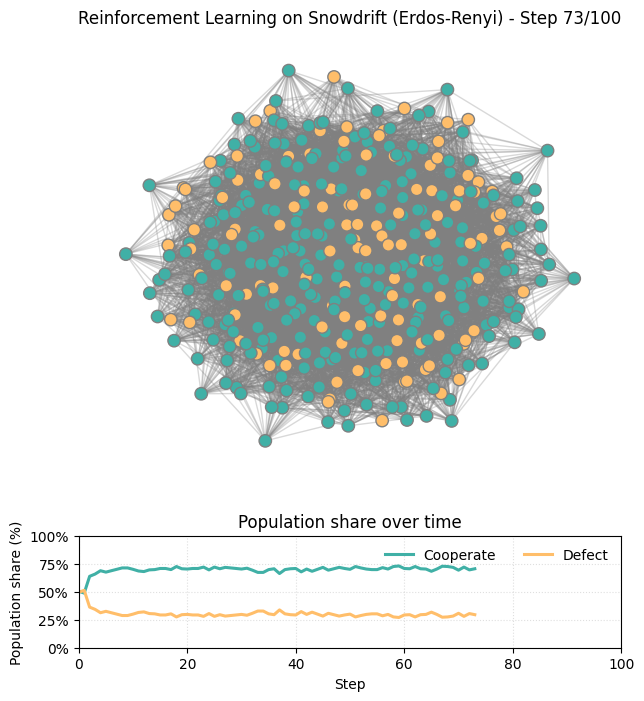

In [57]:
if RUN_ANIMATIONS:
    matrix_names = ["Snowdrift", "Default"]
    size = 20
    n = size * size

    runs = [
        ("Imitation", ImitationStrategy, {}),
        ("Tit-for-Tat", TitForTatStrategy, {}),
        (
            "Reinforcement Learning",
            ReinforcementLearningStrategy,
            {
                "learning_rate": 0.1,
                "epsilon": 0.1,
                "initial_q": 0.0,
            },
        ),
    ]

    graph_setups = [
        ("Grid", "grid", {}, True),
        ("Small-World", "watts_strogatz", {"k": 4, "p": 0.1}, False),
        ("Erdos-Renyi", "erdos_renyi", {"p": 0.1}, False),
    ]

    for matrix_name in matrix_names:
        matrix = payoff_matrices[matrix_name]

        for graph_label, kind, graph_kwargs, is_grid in graph_setups:
            for strat_label, strat_cls, strat_kwargs in runs:
                ani = experiment(
                    network_simulation=NetworkSimulation,
                    strategy_class=strat_cls,
                    strategy_kwargs=strat_kwargs,
                    steps=STEPS,
                    seed=42,
                    interval=100,
                    payoff_matrix=matrix,
                    kind=kind,
                    n=n,
                    is_grid=is_grid,
                    title=f"{strat_label} on {matrix_name} ({graph_label})",
                    **graph_kwargs,
                )
                # display(ani)

## Statistics

In [58]:
STRATEGY_CONFIGS = [
    ("Imitation", ImitationStrategy, {}),
    ("TitForTat", TitForTatStrategy, {}),
    (
        "Reinforcement Learning",
        ReinforcementLearningStrategy,
        {"learning_rate": 0.1, "epsilon": 0.1, "initial_q": 0.0},
    ),
]
MATRIX_CONFIGS = [
    ("Default", payoff_matrices["Default"]),
    ("Snowdrift", payoff_matrices["Snowdrift"]),
]

PLOT_STYLE = {
    "title_size": 13,
    "label_size": 11,
    "tick_size": 10,
    "line_width": 2.0,
    "marker_size": 6,
}

# Global plotting style for readability
plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams.update(
    {
        "figure.dpi": 120,
        "axes.titleweight": "semibold",
        "axes.titlesize": PLOT_STYLE["title_size"],
        "axes.labelsize": PLOT_STYLE["label_size"],
        "xtick.labelsize": PLOT_STYLE["tick_size"],
        "ytick.labelsize": PLOT_STYLE["tick_size"],
        "legend.frameon": False,
    }
)

PARAM_LABELS = {
    "erdos_renyi": "p (edge prob)",
    "watts_strogatz": "p (rewiring)",
    "barabasi_albert": "m (attachment)",
}
NETWORK_LABELS = {
    "erdos_renyi": "Erdos-Renyi",
    "watts_strogatz": "Watts-Strogatz",
    "barabasi_albert": "Barabasi-Albert",
}

In [59]:
def _config_cols(df):
    cols = []
    for col in ["strategy", "matrix"]:
        if col in df.columns and df[col].notna().any() and df[col].nunique() > 1:
            cols.append(col)
    return cols

In [60]:
# -------------------------
# Architecture comparison
# -------------------------
arch_df = None
if RUN_ARCH:
    arch_configs = [
        {"label": "Grid", "kind": "grid", "graph_kwargs": {}, "mean_k": 4},
        {
            "label": "Erdos-Renyi",
            "kind": "erdos_renyi",
            "graph_kwargs": {"p": MEAN_K / (N - 1)},
            "mean_k": MEAN_K,
        },
        {
            "label": "Watts-Strogatz",
            "kind": "watts_strogatz",
            "graph_kwargs": {"k": MEAN_K, "p": 0.1},
            "mean_k": MEAN_K,
        },
        {
            "label": "Barabasi-Albert",
            "kind": "barabasi_albert",
            "graph_kwargs": {"m": MEAN_K // 2},
            "mean_k": MEAN_K,
        },
    ]

    arch_rows = []
    for strat_label, strat_cls, strat_kwargs in STRATEGY_CONFIGS:
        for mat_label, payoff in MATRIX_CONFIGS:
            df = run_architecture_sweep(
                arch_configs,
                n=N,
                payoff_matrix=payoff,
                strategy_class=strat_cls,
                strategy_kwargs=strat_kwargs,
                seeds=SEEDS,
                max_steps=STEPS,
                tail_window=TAIL,
                include_path_metrics=False,
                metric_stride=METRIC_STRIDE,
                strategy_label=strat_label,
                matrix_label=mat_label,
            )
            arch_rows.append(df)

    arch_df = pd.concat(arch_rows, ignore_index=True)
    arch_df["tail_mean_largest_cluster_frac"] = (
        arch_df["tail_mean_largest_cluster"] / arch_df["n"]
    )

    arch_group_cols = ["label"] + _config_cols(arch_df)
    arch_summary = (
        arch_df.groupby(arch_group_cols)[
            [
                "tail_mean_coop_frac",
                "tail_mean_assortment",
                "tail_mean_largest_cluster_frac",
                "avg_clustering",
                "mean_degree",
            ]
        ]
        .mean()
        .reset_index()
        .sort_values("tail_mean_coop_frac", ascending=False)
    )

# -------------------------
# Parameter sweeps
# -------------------------
param_df = None
if RUN_PARAM_SWEEPS:
    ER_PS = np.linspace(0.01, 0.08, 6)
    WS_PS = [0.0, 0.02, 0.05, 0.1, 0.2]
    BA_MS = [2, 3, 4, 5]

    sweep_configs = []
    for p in ER_PS:
        sweep_configs.append(
            {
                "label": "Erdos-Renyi",
                "kind": "erdos_renyi",
                "graph_kwargs": {"p": float(p)},
                "mean_k": float(p * (N - 1)),
                "param_name": "p",
                "param_value": float(p),
            }
        )
    for p in WS_PS:
        sweep_configs.append(
            {
                "label": "Watts-Strogatz",
                "kind": "watts_strogatz",
                "graph_kwargs": {"k": MEAN_K, "p": float(p)},
                "mean_k": MEAN_K,
                "param_name": "p",
                "param_value": float(p),
            }
        )
    for m in BA_MS:
        sweep_configs.append(
            {
                "label": "Barabasi-Albert",
                "kind": "barabasi_albert",
                "graph_kwargs": {"m": int(m)},
                "mean_k": float(2 * m),
                "param_name": "m",
                "param_value": float(m),
            }
        )

    param_rows = []
    for strat_label, strat_cls, strat_kwargs in STRATEGY_CONFIGS:
        for mat_label, payoff in MATRIX_CONFIGS:
            df = run_architecture_sweep(
                sweep_configs,
                n=N,
                payoff_matrix=payoff,
                strategy_class=strat_cls,
                strategy_kwargs=strat_kwargs,
                seeds=SEEDS,
                max_steps=STEPS,
                tail_window=TAIL,
                include_path_metrics=False,
                metric_stride=METRIC_STRIDE,
                strategy_label=strat_label,
                matrix_label=mat_label,
            )
            param_rows.append(df)

    param_df = pd.concat(param_rows, ignore_index=True)
    param_df["tail_mean_largest_cluster_frac"] = (
        param_df["tail_mean_largest_cluster"] / param_df["n"]
    )

    PERCO_THRESH = 0.4
    param_df["percolates"] = param_df["tail_mean_largest_cluster_frac"] >= PERCO_THRESH

    perco_group_cols = ["kind", "param_name", "param_value"] + _config_cols(param_df)
    perco_summary = (
        param_df.groupby(perco_group_cols)["percolates"].mean().reset_index()
    )

    transition_group_cols = ["kind"] + _config_cols(param_df)
    transitions = {}
    for group_key, sub in param_df.groupby(transition_group_cols):
        if not sub["param_value"].notna().any():
            continue
        if not isinstance(group_key, tuple):
            group_key = (group_key,)
        label_bits = [
            f"{col}={val}" for col, val in zip(transition_group_cols, group_key)
        ]
        transitions[" | ".join(label_bits)] = detect_transition(sub, "param_value")

    # print("Approx transition points (max jump in coop):")
    # for label, value in transitions.items():
    # print(f"  {label}: {value}")

# -------------------------
# Robustness checks
# -------------------------
if RUN_ROBUSTNESS:
    robustness_configs = [
        ("Imitation", ImitationStrategy, {}),
        ("Fermi", FermiStrategy, {"temperature": 0.1}),
        ("TitForTat", TitForTatStrategy, {}),
    ]
    robustness_matrices = [
        ("Default", payoff_matrices["Default"]),
        ("Snowdrift", payoff_matrices["Snowdrift"]),
    ]

    robustness_rows = []
    for strat_label, strat_cls, strat_kwargs in robustness_configs:
        for mat_label, payoff in robustness_matrices:
            df = run_architecture_sweep(
                [
                    {
                        "label": "Erdos-Renyi",
                        "kind": "erdos_renyi",
                        "graph_kwargs": {"p": MEAN_K / (N - 1)},
                        "mean_k": MEAN_K,
                    },
                    {
                        "label": "Watts-Strogatz",
                        "kind": "watts_strogatz",
                        "graph_kwargs": {"k": MEAN_K, "p": 0.1},
                        "mean_k": MEAN_K,
                    },
                ],
                n=N,
                payoff_matrix=payoff,
                strategy_class=strat_cls,
                strategy_kwargs=strat_kwargs,
                seeds=SEEDS,
                max_steps=STEPS,
                tail_window=TAIL,
                include_path_metrics=False,
                metric_stride=METRIC_STRIDE,
                strategy_label=strat_label,
                matrix_label=mat_label,
            )
            robustness_rows.append(df)

    robustness_df = pd.concat(robustness_rows, ignore_index=True)
    robustness_summary = (
        robustness_df.groupby(["strategy", "matrix", "label"])[["tail_mean_coop_frac"]]
        .mean()
        .sort_values("tail_mean_coop_frac", ascending=False)
    )

# -------------------------
# Structure sensitivity
# -------------------------
if RUN_STRUCTURE:
    structure_configs = []
    if RUN_PARAM_SWEEPS:
        structure_ps = np.linspace(float(min(WS_PS)), float(max(WS_PS)), 21)
    else:
        structure_ps = [0.0, 0.05, 0.1]
    for p in structure_ps:
        structure_configs.append(
            {
                "label": "Watts-Strogatz",
                "kind": "watts_strogatz",
                "graph_kwargs": {"k": MEAN_K, "p": float(p)},
                "mean_k": MEAN_K,
                "param_name": "p",
                "param_value": float(p),
            }
        )
    structure_rows = []
    for strat_label, strat_cls, strat_kwargs in STRATEGY_CONFIGS:
        for mat_label, payoff in MATRIX_CONFIGS:
            df = run_architecture_sweep(
                structure_configs,
                n=N,
                payoff_matrix=payoff,
                strategy_class=strat_cls,
                strategy_kwargs=strat_kwargs,
                seeds=SEEDS,
                max_steps=STEPS,
                tail_window=TAIL,
                include_path_metrics=True,
                metric_stride=METRIC_STRIDE,
                strategy_label=strat_label,
                matrix_label=mat_label,
            )
            structure_rows.append(df)

    structure_df = pd.concat(structure_rows, ignore_index=True)
    structure_group_cols = ["param_value"] + _config_cols(structure_df)
    structure_summary = (
        structure_df.groupby(structure_group_cols)[
            ["avg_clustering", "tail_mean_coop_frac"]
        ]
        .mean()
        .reset_index()
        .sort_values("avg_clustering")
    )

    if RUN_PLOTS:
        panel_group_cols = _config_cols(structure_df)
        if panel_group_cols:
            panel_groups = list(structure_df.groupby(panel_group_cols))
        else:
            panel_groups = [(None, structure_df)]

        for group_key, group_df in panel_groups:
            fig, ax = plt.subplots(1, 1, figsize=(6, 4))
            stats = (
                group_df.groupby("param_value")[
                    ["avg_clustering", "tail_mean_coop_frac"]
                ]
                .mean()
                .reset_index()
                .sort_values("avg_clustering")
            )
            x = stats["avg_clustering"].to_numpy()
            y = stats["tail_mean_coop_frac"].to_numpy()
            ax.scatter(
                x,
                y,
                s=(PLOT_STYLE["marker_size"] + 2) ** 2,
                alpha=0.8,
                edgecolors="white",
                linewidth=0.6,
                color="#2F6BFF",
            )
            ax.set_xlabel("Average clustering", fontsize=PLOT_STYLE["label_size"])
            ax.set_ylabel("Coop fraction", fontsize=PLOT_STYLE["label_size"])
            title = "Structure sensitivity: clustering vs cooperation (tail mean)"
            if panel_group_cols:
                if not isinstance(group_key, tuple):
                    group_key = (group_key,)
                label_bits = [
                    f"{col}={val}" for col, val in zip(panel_group_cols, group_key)
                ]
                title = f"{title} ({' | '.join(label_bits)})"
                plot_suffix = "__".join(label_bits)
            else:
                plot_suffix = "all"
            ax.set_title(title, fontsize=PLOT_STYLE["title_size"])
            ax.grid(True, linestyle=":", alpha=0.4)
            ax.tick_params(labelsize=PLOT_STYLE["tick_size"])
            plt.tight_layout()
            save_fig(fig, f"structure_sensitivity_{plot_suffix}")
# -------------------------
# Uncertainty: error bands across seeds
# -------------------------
if RUN_UNCERTAINTY and RUN_PARAM_SWEEPS and param_df is not None:
    uncertainty_group_cols = _config_cols(param_df)
    if uncertainty_group_cols:
        uncertainty_groups = list(param_df.groupby(uncertainty_group_cols))
    else:
        uncertainty_groups = [(None, param_df)]

    for group_key, group_df in uncertainty_groups:
        fig, axes = plt.subplots(1, 3, figsize=(12, 3.6), sharey=True)
        kinds = ["erdos_renyi", "watts_strogatz", "barabasi_albert"]
        for ax, kind in zip(axes, kinds):
            sub = group_df[group_df["kind"] == kind]
            if sub.empty:
                ax.axis("off")
                continue
            param_name = sub["param_name"].dropna().iloc[0]
            label = NETWORK_LABELS.get(kind, kind)
            stats = (
                sub.groupby("param_value")["tail_mean_coop_frac"]
                .agg(["mean", "std"])
                .sort_index()
            )
            ax.plot(
                stats.index,
                stats["mean"],
                marker="o",
                linewidth=PLOT_STYLE["line_width"],
            )
            ax.fill_between(
                stats.index,
                stats["mean"] - stats["std"],
                stats["mean"] + stats["std"],
                alpha=0.2,
            )
            ax.set_title(
                f"{label}: cooperation (mean +/- 1 std)",
                fontsize=PLOT_STYLE["title_size"],
            )
            ax.set_xlabel(
                PARAM_LABELS.get(kind, param_name), fontsize=PLOT_STYLE["label_size"]
            )
            ax.grid(True, linestyle=":", alpha=0.4)
            ax.tick_params(labelsize=PLOT_STYLE["tick_size"])
        axes[0].set_ylabel("Coop fraction", fontsize=PLOT_STYLE["label_size"])
        if uncertainty_group_cols:
            if not isinstance(group_key, tuple):
                group_key = (group_key,)
            label_bits = [
                f"{col}={val}" for col, val in zip(uncertainty_group_cols, group_key)
            ]
            fig.suptitle(
                "Cooperation uncertainty across seeds (mean +/- 1 std)"
                + f" ({' | '.join(label_bits)})",
                y=1.02,
                fontsize=12,
            )
            plot_suffix = "__".join(label_bits)
        else:
            plot_suffix = "all"
        plt.tight_layout()
        save_fig(fig, f"uncertainty_{plot_suffix}")
# -------------------------
# Plots: architecture
# -------------------------
if RUN_PLOTS and RUN_ARCH and arch_df is not None:
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    plot_df = arch_summary.copy()
    label_order = [cfg["label"] for cfg in arch_configs]
    plot_df["label"] = pd.Categorical(
        plot_df["label"], categories=label_order, ordered=True
    )
    if arch_group_cols:
        plot_df["config"] = plot_df[arch_group_cols].astype(str).agg(" | ".join, axis=1)
    else:
        plot_df["config"] = plot_df["label"]
    plot_df = plot_df.sort_values(
        ["label", "tail_mean_coop_frac"], ascending=[True, False]
    ).set_index("config")
    plot_df["tail_mean_coop_frac"].plot(kind="bar", ax=ax)
    ax.set_title(
        "Architecture comparison: mean cooperation (tail average)",
        fontsize=PLOT_STYLE["title_size"],
    )
    ax.set_ylabel("Coop fraction", fontsize=PLOT_STYLE["label_size"])
    ax.grid(True, linestyle=":", alpha=0.4)
    ax.tick_params(labelsize=PLOT_STYLE["tick_size"])
    plt.tight_layout()
    save_fig(fig, "architecture_mean_cooperation")
# -------------------------
# Plots: per-network parameter panels (grid, shared y)
# -------------------------
if RUN_PLOTS and RUN_PARAM_SWEEPS and param_df is not None:
    metrics = [
        "tail_mean_coop_frac",
        "tail_mean_assortment",
        "tail_mean_largest_cluster_frac",
    ]
    metric_titles = {
        "tail_mean_coop_frac": "Cooperation",
        "tail_mean_assortment": "Assortment",
        "tail_mean_largest_cluster_frac": "Largest coop cluster",
    }

    panel_group_cols = _config_cols(param_df)
    if panel_group_cols:
        panel_groups = list(param_df.groupby(panel_group_cols))
    else:
        panel_groups = [(None, param_df)]

    for group_key, group_df in panel_groups:
        kinds = list(group_df["kind"].dropna().unique())
        if not kinds:
            continue
        n_rows = len(kinds)
        n_cols = len(metrics)
        fig, axes = plt.subplots(
            n_rows,
            n_cols,
            figsize=(3.6 * n_cols, 2.8 * n_rows),
            sharey="col",
        )
        title = "Parameter sweeps by network (tail averages)"
        if panel_group_cols:
            if not isinstance(group_key, tuple):
                group_key = (group_key,)
            label_bits = [
                f"{col}={val}" for col, val in zip(panel_group_cols, group_key)
            ]
            title = f"{title} ({' | '.join(label_bits)})"
            plot_suffix = "__".join(label_bits)
        else:
            plot_suffix = "all"
        fig.suptitle(title, y=1.02, fontsize=12)
        if n_rows == 1:
            axes = [axes]

        for i, kind in enumerate(kinds):
            sub = group_df[group_df["kind"] == kind]
            param_name = sub["param_name"].dropna().iloc[0]
            label = NETWORK_LABELS.get(kind, kind)
            summary = sub.groupby("param_value")[metrics].mean().sort_index()

            row_axes = axes[i] if n_rows > 1 else axes[0]
            for j, metric in enumerate(metrics):
                ax = row_axes[j]
                ax.plot(
                    summary.index,
                    summary[metric],
                    marker="o",
                    linewidth=PLOT_STYLE["line_width"],
                )
                if i == 0:
                    ax.set_title(
                        metric_titles[metric], fontsize=PLOT_STYLE["title_size"]
                    )
                if j == 0:
                    ax.set_ylabel(
                        f"{label}",
                        fontsize=PLOT_STYLE["label_size"],
                    )
                ax.grid(True, linestyle=":", alpha=0.4)
                ax.tick_params(labelsize=PLOT_STYLE["tick_size"])

            mid_col = n_cols // 2
            row_axes[mid_col].set_xlabel(
                PARAM_LABELS.get(kind, param_name),
                fontsize=PLOT_STYLE["label_size"],
            )

        plt.tight_layout()
        save_fig(fig, f"parameter_sweeps_{plot_suffix}")

/Users/tristanfarran/.default-py/lib/python3.13/site-packages/networkx/algorithms/assortativity/correlation.py:302: RuntimeWarning: invalid value encountered in scalar divide
  return float((xy * (M - ab)).sum() / np.sqrt(vara * varb))
/Users/tristanfarran/.default-py/lib/python3.13/site-packages/networkx/algorithms/assortativity/correlation.py:302: RuntimeWarning: invalid value encountered in scalar divide
  return float((xy * (M - ab)).sum() / np.sqrt(vara * varb))
/var/folders/80/qjcx023s5dsfl5g98wkn22yc0000gn/T/ipykernel_16743/1041689068.py:398: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


## Interpretation

The simulations show that cooperation is a dynamical regime that appears when either (i) the game incentives structurally support coexistence (Snowdrift), or (ii) the strategy rule enforces reciprocity over time (Tit-for-Tat). In contrast, under Default Prisoner’s-Dilemma-like incentives with payoff-driven adaptation, the system reliably collapses toward all-defection, often as an absorbing-state process. Network topology matters mainly by shaping the geometry and spatial form of cooperation, not by determining whether cooperation is viable in the first place.

⸻

### Axis A — Game incentives: PD vs Snowdrift

#### Default (Prisoner’s Dilemma-like)

- Defection is structurally favored (one-shot incentive logic).
- Under payoff-driven adaptation, the system tends toward an all-defect absorbing state.
- Once the system hits all-D, there is no mechanism to reintroduce cooperation.
- Small cooperative “droplets” cannot nucleate and grow.

**Interpretation:**  
Default PD wants fixation (typically all-D), and payoff-based learning rules amplify that.

⸻

#### Snowdrift (Hawk–Dove / Chicken)

- Cooperation and defection are both locally viable, depending on neighborhood composition.
- Payoffs are frequency-dependent:
  - if surrounded by cooperators, defection does well,
  - if surrounded by defectors, cooperation does well.
- This creates a restoring force toward a stable interior mix → persistent coexistence.
- The system stabilizes into a mixed equilibrium (high mean cooperation, not fixation).

**Interpretation:**  
Snowdrift wants coexistence (mixed equilibrium), producing an active phase with persistent turnover.

⸻

### Axis B — Update rule: imitation/RL vs Tit-for-Tat

#### Imitation (payoff-based copying) = local selection / replicator-like dynamics

- Strategies spread if they earn higher payoff locally.
- It strongly amplifies the game’s equilibrium attractor:
  - Default + imitation → rapid sweep to defection
  - Snowdrift + imitation → stable mixed population (no fixation)

**Interpretation:**  
Imitation is a selection-pressure amplifier: it does not create prosociality, it reproduces incentives.

⸻

#### Reinforcement Learning (RL): “learning is not pro-social, it is pro-payoff”

- Snowdrift + RL → high cooperation across architectures (expected, since mutual defection isn’t the dominant attractor).
- Default + RL → near-zero cooperation (tiny bars ~0.00–0.06), matching true PD logic:
  - defection strictly dominates in one-shot payoff terms
  - without reciprocity enforcement, learning pushes toward defection

**Interpretation:**  
RL reproduces the equilibrium structure of the game; it does not generate cooperation intrinsically.

⸻

#### Tit-for-Tat (TFT) = reciprocity enforcement in repeated play

- TFT changes the effective payoff landscape over time:
  - defection is no longer a one-way exploit
  - retaliation removes the free lunch
  - defectors can’t exploit indefinitely
- Default + TFT → cooperation survives at substantial levels
- bars ~0.39–0.41 across network types (not near zero)
- Two TFT agents meeting → stable cooperation stream.
- Defectors can exploit once, but are punished immediately.
- On structured graphs (especially grids), TFT can form long-lived cooperative domains, sometimes approaching near-total cooperation.

**Interpretation:**  
TFT is a reciprocal enforcement mechanism that can stabilize cooperation even in PD-like environments.

⸻

### Axis C — Network topology: controls the spatial form of cooperation

#### Erdős–Rényi (random)

- Looks well-mixed (low clustering, short paths).
- Default + imitation → fast global collapse to defection (rapid sweep).
- Snowdrift → speckled shimmer of C/D (“salt-and-pepper” coexistence).

**Visual signature:** fast mixing, mean-field-like behavior.

⸻

#### Grid (lattice)

- Strong locality → spatial shielding and correlated neighborhoods.
- Produces domains/blobs of cooperators and defectors.
- Dynamics happen at interfaces:
  - interiors persist,
  - boundaries move, drift, reshape.
- Under TFT, cooperative clusters become fortress-like and can dominate.

**Visual signature:** continents/blobs + slow boundary motion (coarsening).

⸻

#### Small-world

- Hybrid of grid locality + random shortcuts.
- Still forms clusters, but shortcuts cause long-range invasions.
- More turbulent than grid, less well-mixed than ER.

**Visual signature:** patches + sudden disruptions (“invasions through the air”).

⸻

### Regimes observed (mapping to your plots + GIFs)

#### 1) Default PD + imitation (especially on ER): absorbing-state collapse

- Starts mixed → defection spreads → cooperation collapses → ends near all-D.
- Mechanism: defection has consistent local advantage; imitation amplifies it; ER accelerates it via mixing.

**Conclusion:**  
PD + imitation ⇒ absorbing all-D, a correct “control experiment” where cooperation does not emerge.

⸻

#### 2) Snowdrift: active mixed phase (persistent fluctuations)

- System does not freeze.
- Macroscopic observables fluctuate around a stable mean cooperation level.
- Microscopic updates continue indefinitely.
- Spatial domains appear clearly on structured networks:
  - interior stable,
  - evolution at interfaces.

**Conclusion:**  
Snowdrift produces a robust coexistence regime across architectures.

⸻

#### 3) TFT rescues cooperation in Default PD (reciprocity-stabilized coexistence)

- No collapse to all-D even when defection is locally profitable.
- Cooperation survives at intermediate levels across architectures (~0.39–0.41).
- Grid + TFT strengthens stability: long-lived cooperative structures.

**Conclusion:**  
Reciprocity enforcement can stabilize cooperation even under adverse incentives.

⸻

### What “emergence of cooperation” means in your results (precisely)

You observed three qualitatively distinct mechanisms:

1. **Equilibrium coexistence (Snowdrift)**  
   Cooperation persists because the payoff structure supports a stable interior mixed equilibrium.

2. **Reciprocity enforcement (Tit-for-Tat)**  
   Cooperation persists because retaliation prevents sustained exploitation, altering repeated-game incentives.

3. **Selection-driven collapse (Default + imitation/RL)**  
   Cooperation fails because payoff-based adaptation amplifies local advantage and drives the system to the absorbing all-D state.

So:  
Cooperation emerges either because the game allows it (Snowdrift) or because strategy dynamics enforce it (TFT), while imitation/RL alone reproduces baseline equilibrium logic (defection in PD).

⸻

### Main results (report-ready)

**Result 1 — Incentives dominate topology**  
Across all network architectures, the payoff matrix determines whether cooperation is viable: Snowdrift supports stable mixed cooperation, while Default PD collapses under payoff-driven adaptation.

**Result 2 — Reciprocity rules rescue cooperation even in PD**  
Tit-for-Tat sustains intermediate cooperation even when payoff-driven learners converge to defection, showing that conditional reciprocity can stabilize cooperative clusters in adverse incentive environments.

**Result 3 — Learning is not pro-social, it is pro-payoff**  
Reinforcement learning yields high cooperation in Snowdrift but near-zero cooperation in Default, demonstrating that learning dynamics reproduce the equilibrium structure of the underlying game.

**Result 4 — Network effects are secondary in this regime**  
Differences between grid, random, small-world, and scale-free networks are present but modest compared to game and update-rule effects, implying that adaptation dynamics overpower structural clustering advantages here.

⸻

### One-sentence final claim (strong + correct)

Cooperation emerges not because agents become altruistic, but because either the incentive structure supports stable coexistence (Snowdrift) or reciprocity prevents exploitation (Tit-for-Tat), while network topology mainly determines whether coexistence appears as fast well-mixed shimmer (ER) or slow domain/interface dynamics (grid/small-world).

⸻

### Complex-systems framing (optional but defensible)

- Absorbing vs active phase:
  - Default PD + imitation behaves like an absorbing-state system (all-D absorbing).
  - Snowdrift behaves like an active mixed phase (persistent turnover).
- Order parameter: cooperation fraction C(t).
- Morphology matters: cluster size distribution, interface length, persistence times.
- Topology as a control parameter: moving grid → small-world → ER increases mixing, shifting from domain coarsening to mean-field speckle.
- Percolation intuition: on grids/small-world, cooperative clusters can become large and persistent; one can ask whether cooperative regions “span” the network (giant component / percolating cluster), even if mean cooperation < 1.